# Wonky Tops
### Marina Ten, Floris Strijbos, Tom Wade

In [1]:
import pandas as pd
import numpy as np
import ipyvolume as ipv

In [2]:
%pwd

'C:\\Users\\Thomas.Wade\\OneDrive - Shell\\python\\hackathon\\git\\wonkeycontact'

In [3]:
#Read Input tops data from excel file
from pandas import read_excel
my_sheet_name = 'Sheet1' 
df = read_excel('11_2.xlsx', sheet_name = my_sheet_name)

In [4]:
#df.loc[:,['UID','Well','Top','Interpreter','Depth_MD','Easting','Northing','Depth_tvdss']]

In [5]:
#df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']]

In [6]:
#Extract XYZ from dataframe
xyz=df.loc[df.Top.isin(['AS11.2','T AS11.2']), ['Easting','Northing','Depth_tvdss']].values

In [7]:
#Exctract XYZ values for processing
x=xyz[:,0]
y=xyz[:,1]
z=xyz[:,2]

In [8]:
#Get extents of input data
xmin=x.min() ; ymin=y.min() ; xmax=x.max() ; ymax=y.max() ; zmin=z.min() ; zmax=z.max()

### Initial processing to mathematically remove obvious outliers

In [9]:
def outliers_iqr(z):
    """
    The interquartile range (IQR), also called the midspread or middle 50%, 
    or technically H-spread, is a measure of statistical dispersion, being equal to the difference 
    between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
    In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles 
    can be clearly seen on a box plot on the data.
    It is a measure of the dispersion similar to standard deviation or variance, but is much more robust 
    against outliers.
    """
    quartile_1, quartile_3 = np.percentile(z, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((z > upper_bound) | (z < lower_bound))
iqr_test = outliers_iqr(z)[0].tolist()
x_smooth = np.delete(x,iqr_test)
y_smooth = np.delete(y,iqr_test)
z_smooth = np.delete(z,iqr_test)
ipv.figure()
s = ipv.scatter(x_smooth, y_smooth, z_smooth, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Iterative interactive editing, round1

In [10]:
#Select points in plot above interactively, using CTRL-R
s_sel=s.selected
k=s_sel[0].tolist()

In [11]:
#Pick up points edited in first 'outlier edit' funtion
x= x_smooth
y = y_smooth
z = z_smooth

In [12]:
#Delete the points
xdel=np.delete(x,k)
ydel=np.delete(y,k)
zdel=np.delete(z,k)

In [13]:
#Redraw the plot with the update pointset
ipv.figure()
sdel = ipv.scatter(xdel, ydel, zdel, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Second edit iteration

In [14]:
#Select points in plot above, using CTRTL-R. Then procede to select and delete:
k2=sdel.selected[0].tolist()

In [15]:
#Delete the selected points
xdel2=np.delete(xdel,k2)
ydel2=np.delete(ydel,k2)
zdel2=np.delete(zdel,k2)

In [16]:
#Redraw the plot. Presume no further edits after this
ipv.figure()
sdel2 = ipv.scatter(xdel2, ydel2, zdel2, marker='sphere', size=3)
ipv.xlim(xmin,xmax)
ipv.ylim(ymin,ymax)
ipv.zlim(-4000,-1500)
ipv.animation_control(s)# shows controls for animation controls
ipv.selector_default()
ipv.show()

Output()

### Grid up  edited data

In [17]:
#Reassign edited data to X,Y,Z variable
x, y, z = xdel2, ydel2, zdel2

### Grid Tops via minimum curvature
##### Note this was our first gridding approach. However, a depopulated appoach is going to be preferred...

In [18]:
#Create a grid outline from tops data extent. Start printing extent
print("Xmin = {} , XMax = {}\nYmin = {}, Ymax= {}\nZmin = {}, Zmax = {}".format(xmin, xmax, ymin, ymax, zmin, zmax))

Xmin = 595608.87 , XMax = 628209.11
Ymin = 6639937.51, Ymax= 6699306.54
Zmin = -3000.22, Zmax = -2108.3


In [19]:
#Create sensible grid outline of integers. Currently hardcoded...
extent = [596000, 628500, 6640000, 6700000] #Sensible numbers from observed Xmin and Ymin. Defines Grid
grid_int = 100 #Hard coded grid spacing
#Create arrays of the x and y axis
x_points = int((extent[1] - extent[0]) / grid_int) #Number of samples in the X-Direction
y_points = int((extent[3] - extent[2]) / grid_int) #Number of samples in the Y-Direction

In [20]:
#Create the grid. interval expressed by complex numbers
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(x_points), extent[2]:extent[3]:complex(y_points)]

In [21]:
#Create numpy arrays of point co-ordinates and then values from input data
points = np.array(list(zip(x, y)))
values = z

In [22]:
#Perform interpolation of data in to the specified grid using scipy
from scipy.interpolate import griddata
gridded = griddata(points, values, (grid_x, grid_y), method='cubic')

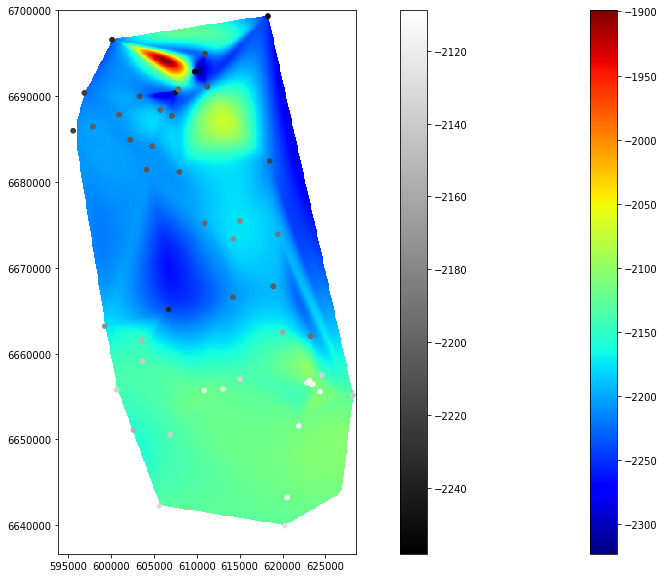

In [23]:
#Initial plot, Pre-Residuals. Can probs delete later
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(gridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()
plt.scatter(x, y, s=20, c=z)

plt.gray()
plt.colorbar()

### Residuals Extraction

In [24]:
import bruges #Utilise the coordinate transformation functions

In [25]:
# UTM coords of 3 unique inline, crossline locations. Taken from grid extents (realworld)
corners_xy = np.array([[596000, 6640000],
                       [596000, 6700000],
                       [628500, 6640000]])

# The inline, crossline locations you just provided. Also Grid extent, but as indices given by grid.shape
corners_ix = np.array([[0,  0],
                       [0, 600],
                       [325, 0]])

In [26]:
transform = bruges.transform.CoordTransform(corners_ix, corners_xy)

In [27]:
#Pissing about to  create lists of well-top coordinates (as currently in np.array). Then transform
def get_top_coords(xIn, yIn):
    xlist = xIn.tolist()
    ylist = yIn.tolist()
    merge = list(zip(xlist, ylist))
    coordinatesOut = []
    for i in merge:
        coordinatesOut.append(transform.reverse([i[0], i[1]]))
    xcors = np.array([item[0] for item in coordinatesOut])
    ycors = np.array([item[1] for item in coordinatesOut])
    return xcors , ycors

In [28]:
xCor, yCor = get_top_coords(x, y)

In [29]:
#Extract the value of the grid at the well top locations
z_gridded = gridded[(xCor, yCor)]

In [30]:
#Calculate the residuals by subtracting gridded value from input top value
residuals = z - z_gridded

In [31]:
#Put the residuals in to a dataframe for visualisation
d = {'x': x, 'y': y, 'z':z, 'z_gridded': z_gridded, 'residual': residuals}
res_df = pd.DataFrame(data=d)
res_df.head()

,x,y,z,z_gridded,residual
0,626877.718685,6.643734e+06,-2113.2766,NaN,NaN
1,610893.850000,6.655695e+06,-2121.6533,-2121.869510,0.216210
2,621876.789795,6.651567e+06,-2115.5544,-2115.562777,0.008377
3,620549.130000,6.643251e+06,-2122.0000,-2118.464128,-3.535872
4,615070.760003,6.657014e+06,-2134.3901,-2134.559270,0.169170


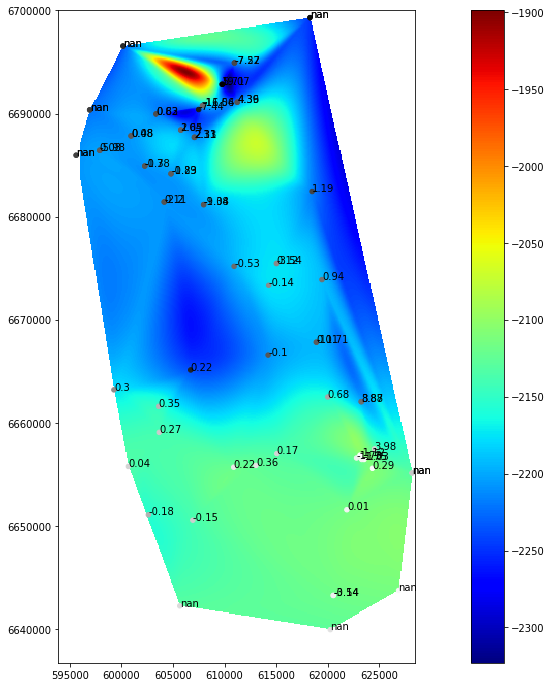

In [32]:
#Plot image of grid, this time with residual annotations
plt.figure(figsize=(20,12))
plt.imshow(gridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()

#Plot well tops and residuals
plt.scatter(x, y, s=20, c=z)

res_list = residuals.tolist()
res_list_txt = [str(round(i, 2)) for i in res_list]

for i, txt in enumerate(res_list_txt):
    plt.annotate(txt, (x[i], y[i]) , size=10)

### Residual Histogram

C:\Apps\anaconda\envs\geocomp2\lib\site-packages\numpy\lib\histograms.py:329: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Apps\anaconda\envs\geocomp2\lib\site-packages\numpy\lib\histograms.py:330: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Apps\anaconda\envs\geocomp2\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Apps\anaconda\envs\geocomp2\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


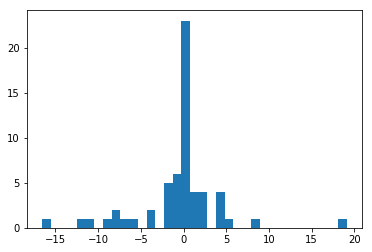

In [33]:
rng = np.nanmin(res_list), np.nanmax(res_list)
n, bins, _ = plt.hist(res_list, bins='auto',  range=rng)

In [34]:
bins = (bins[1:] + bins[:-1]) / 2

<BarContainer object of 35 artists>

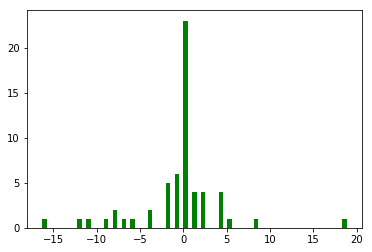

In [35]:
plt.bar(bins, n, width=0.5, color='g')

### Regrid using data with outliers kicked out

In [36]:
#Filter the input data on the results of tghe first gridding
condition1 = ( (res_df.residual > -5) & (res_df.residual < 5) )
condition2 = res_df.residual.isna()

filteredDf = res_df[condition1 | condition2]

In [37]:
#Pull data from the filtered pandas data frame into 1d arrays
xFilt, yFilt , zFilt = filteredDf.x , filteredDf.y , filteredDf.z

In [38]:
#Create numpy arrays of point co-ordinates and then values from input data
pointsFilt = np.array(list(zip(xFilt, yFilt)))
valuesFilt = zFilt

In [39]:
#Perform interpolation of data in to the specified grid using scipy
reGridded = griddata(pointsFilt, valuesFilt, (grid_x, grid_y), method='cubic')

In [40]:
#Determine array value limits for contour plotting
contourInt = 5
contourMin = round(int(np.nanmin(reGridded)), -1)
contourMax = round(int(np.nanmax(reGridded)), -1)
contours = np.arange(contourMin, contourMax, contourInt)

In [41]:
#Re-extract residuals
newXcor, newYcor = get_top_coords(xFilt, yFilt)

In [42]:
#Extract the value of the grid at the well top locations
z_reGridded = reGridded[(newXcor, newYcor)]
newResiduals = zFilt - z_reGridded

In [43]:
#Put the residuals in to a dataframe for visualisation
d_regrid = {'x': xFilt, 'y': yFilt, 'z':zFilt, 'z_regridded': z_reGridded, 'residual': newResiduals}
reGrid_df = pd.DataFrame(data=d_regrid)
reGrid_df

,x,y,z,z_regridded,residual
0,626877.718685,6.643734e+06,-2113.2766,NaN,NaN
1,610893.850000,6.655695e+06,-2121.6533,-2121.868296,0.214996
2,621876.789795,6.651567e+06,-2115.5544,-2115.572130,0.017730
3,620549.130000,6.643251e+06,-2122.0000,-2118.463933,-3.536067
4,615070.760003,6.657014e+06,-2134.3901,-2134.559262,0.169162
5,602615.130000,6.651081e+06,-2154.7600,-2154.581594,-0.178406
6,628209.110000,6.655140e+06,-2131.0300,NaN,NaN
7,624352.917232,6.655587e+06,-2110.4792,-2110.770168,0.290968
8,623525.361332,6.656440e+06,-2111.0015,-2109.968667,-1.032833
9,603620.910000,6.661603e+06,-2150.8799,-2151.232702,0.352802


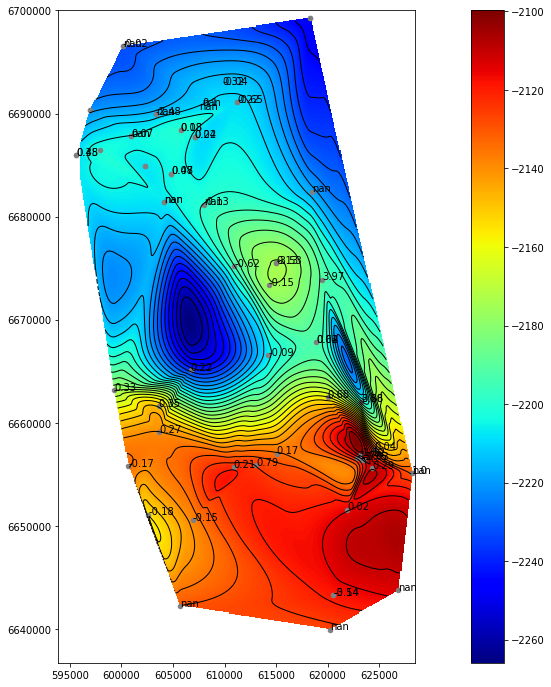

In [48]:
#Plot image of grid, this time with residual annotations
plt.figure(figsize=(20,12))
plt.imshow(reGridded.T, origin='lower', extent=extent, cmap='jet')
plt.colorbar()

#ContourLevels
plt.contour(reGridded.T, extent=extent, levels=contours, colors='k', linestyles='-', linewidths=1)

#Plot well tops and residuals
plt.scatter(xFilt, yFilt, s=20, c='gray')


new_res_list = newResiduals.tolist()
new_res_list_txt = [str(round(i, 2)) for i in new_res_list]


for i, txt in enumerate(new_res_list_txt):
    plt.annotate(txt, (x[i], y[i]) , size=10)

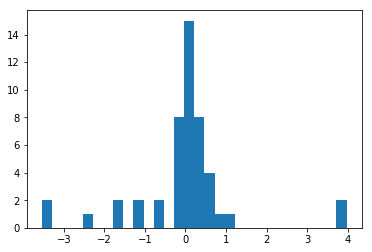

In [51]:
#Update histogram
rng2 = np.nanmin(new_res_list), np.nanmax(new_res_list)
n, bins, _ = plt.hist(new_res_list, bins='auto',  range=rng2)

### 2d Fourier Transform

In [ ]:
#Subset data to rectangle. In final version, will have already selected rectangle in ipyvolume phase

In [ ]:
gridded.shape

In [ ]:
ft = np.fft.fft2(gridded)